 # <b> <font color='red' size=25>CODING ATTENTION FROM SCRATCH FOR LANGUAGE TRANSLATION </font> </b>
 
<b><font color = "white" size = 6.5>-----------------------------------------</font> <font color = "green" size = 6.5>Rohan Thoma</font></b>

<img src='https://imgur.com/HEwk3T7.jpg'>

## <b>Reference papers</b>

<b>Paper 1</b>: Effective approach to attention based neural machine translation:
https://arxiv.org/pdf/1409.0473.pdf

<b>Paper 2</b>: Neural Machine Translation by jointly learning to align and translate:
https://arxiv.org/pdf/1508.04025.pdf


### <font color='blue'>**Downloading required files**</font>

> lets download the data which have italian words along with its english translaton

In [ ]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip


--2020-09-17 17:30:51--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.24.108.196, 104.24.109.196, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7468237 (7.1M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.12M  4.28MB/s    in 1.7s    

2020-09-17 17:30:53 (4.28 MB/s) - ‘ita-eng.zip’ saved [7468237/7468237]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


> lets download the glove vectors ("vectors for english words"), note that this file will have vectors with 50d, 100d and 300d, you can choose any one of them based on your computing power

Here we will be passing english text to the decoder, so we will be using these vectors in decoder embedding layer

In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2020-08-29 17:23:15--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2020-08-29 17:23:15--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca40c7c23141e02ee0b88baa137.dl.dropboxusercontent.com/cd/0/inline/A-Zh8w3W9V509FRBs2Q6z_vIl5GAHk325hebibhDv3NCe7pjEvoG-xT_xgCzmCOenx8fE2dMHRArTYUpSihBcBOjI51uki4e2K5g35Epb2UQKxc7DmKiP140HbwpUBfvSBM/file# [following]
--2020-08-29 17:23:16--  https://uca40c7c23141e02ee0b88baa137.dl.dropboxusercontent.com/cd/0/inline/A-Zh8w3W9V509FRBs2Q6z_vIl5GAHk325hebibhDv3NCe7pjEvoG-xT_xgCzmCOenx8fE2dMHRArTYUpSihBcBOjI51uki4e

### <font color='blue'>**Loading data**</font>

> if you observe the data file, each feild was seperated by a tab '\t'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(352894, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.shape


(352894, 2)

In [ ]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(341554, 2)


,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    text = text.strip()
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    text = text.strip()
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [ ]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 9.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 22.0
100 92.0


In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 25.0
100 101.0


> <font color="blue"><b>If you observe the values, 99.9% of the data points are having length &lt; 20, so select the sentences that have words &lt; 20 </b> </font>
<br>
<br>
> <font color="green"><b>Inorder to do the teacher forcing while training of seq-seq models, lets create two new columns, one with  &lt;start&gt; token at begining of the sentence and other column with &lt;end&gt; token at the end of the sequence</b></font>

In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [ ]:
data.sample(10)

,italian,english_inp,english_out
30968,tom viveva da solo,<start> tom lived alone,tom lived alone <end>
180934,voi siete mai stati sposati,<start> have you ever been married,have you ever been married <end>
106525,io sono il nuovo partner di tom,<start> i am tom is new partner,i am tom is new partner <end>
295740,ho fatto diversi errori allesame,<start> i made several mistakes in the exam,i made several mistakes in the exam <end>
345465,noi avevamo degli aerei però abbiamo dovuto ve...,<start> we used to have airplanes but we had t...,we used to have airplanes but we had to sell t...
58454,non vada lì ora,<start> do not go there now,do not go there now <end>
20731,è eccellente,<start> it is excellent,it is excellent <end>
215006,ho un problema con la mia macchina,<start> i have a problem with my car,i have a problem with my car <end>
324452,la mia camera è tre volte più grande della sua,<start> my room is three times as large as yours,my room is three times as large as yours <end>
96085,tom vive allestero,<start> tom is living abroad,tom is living abroad <end>


### Teacher Forcing
<pre>
Let us consider the example data point

italian: erano occupate	
english_inp: &lt;start> they were busy	
                |     |     |    |
english_out:  they   were busy &lt;end>

if you observe the sentences, the start token is getting mapped to the first word in your english sentence, the first word is mapped to 2nd word, the 2nd word mapped to 3rd word and so on, finall the last one will is mapped to end token. i.e i the word will be mapped to i+1th word.

As we will be passing "english_inp" as an input to the decoder and the outputs(predictions) of the decoder will be compared against the "english_out" 

with this way of mapping, we can ensure that the model will predict the next word and calculate the loss accordingly.

</pre>

### Getting train and test 

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)
print(train.shape, validation.shape)

(281922, 3) (70481, 3)


In [ ]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(281922, 3) (70481, 3)


In [ ]:
train.head()

,italian,english_inp,english_out
1259,scusami,<start> excuse me <end>,excuse me <end> <end>
183812,ho incontrato tom solo tre volte,<start> i only met tom three times,i only met tom three times <end>
43560,dovè la sua chiave,<start> where is your key,where is your key <end>
168566,parlo inglese tutti i giorni,<start> i speak english every day,i speak english every day <end>
29067,mi fa male il collo,<start> my neck is sore,my neck is sore <end>


In [ ]:
validation.head()

,italian,english_inp,english_out
28746,sono le otto passate,<start> it is past eight,it is past eight <end>
246954,lei sarà in ritardo per la riunione,<start> she will be late for the meeting,she will be late for the meeting <end>
175490,tom dovrebbe lasciarmelo fare,<start> tom should let me do that,tom should let me do that <end>
252681,lei aveva ragione e io avevo torto,<start> you were right and i was wrong,you were right and i was wrong <end>
126342,tom ha avuto un attacco di cuore,<start> tom had a heart attack,tom had a heart attack <end>


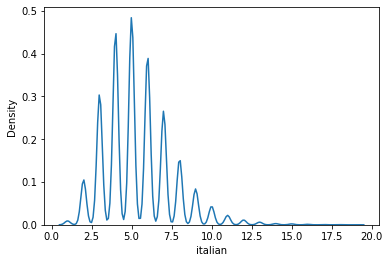

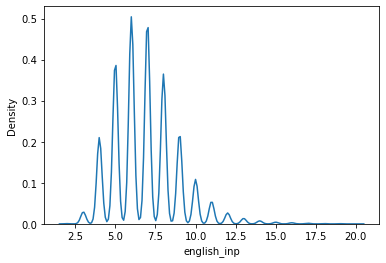

In [ ]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

### Creating Tokenizer on the train data and learning vocabulary

In [ ]:
tknizer_ita = Tokenizer(filters='',oov_token='<UNK>')
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='',oov_token='<UNK>')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [ ]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

13046
26605


In [ ]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(2, 10338)

### Creating embeddings for english sentences

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Creating data pipeline

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  #model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=512)
test_dataloader = Dataloder(test_dataset, batch_size=512)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(512, 20) (512, 20) (512, 20)


## Task-1 Implementing a custom encoder decoder

#### <b><font color='red'>Encoder</font></b>

In [ ]:
class Encoder(tf.keras.Model):
  '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
  '''

  def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
    super().__init__()
    #Initialize Embedding layer
    #Intialize Encoder LSTM layer
    self.inp_vocab_size=inp_vocab_size
    self.embedding_size=embedding_size
    self.lstm_size=lstm_size
    self.input_length=input_length
    self.lstm_output = 0
    self.lstm_state_h = 0
    self.lstm_state_c = 0
    self.embedding = Embedding(input_dim=self.inp_vocab_size+1, output_dim=self.embedding_size, input_length=self.input_length,\
                           mask_zero=True, name="embedding_layer_encoder")
    self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")

  def call(self,input_sequence,states,training=True):
    '''
    This function takes a sequence input and the initial states of the encoder.
    Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
    returns -- encoder_output, last time step's hidden and cell state
    '''
    input_embedd = self.embedding(input_sequence)
    self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd, initial_state=states)
    
    return self.lstm_output, self.lstm_state_h,self.lstm_state_c
    
  def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      self.lstm_state_h = tf.zeros(shape=(batch_size,self.lstm_size))
      self.lstm_state_c = tf.zeros(shape=(batch_size,self.lstm_size))
      
      return [self.lstm_state_h,self.lstm_state_c]
      


#### <b><font color='red'>Decoder</font></b>

In [ ]:
class Decoder(tf.keras.Model):
  '''
    Decoder model -- That takes a input sequence, encoder states and returns output sequence,decoder_final_state_h,decoder_final_state_c
  '''

  def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length,emb_matrix=None):
    super().__init__()
    #Initialize Embedding layer
    #Intialize Decoder LSTM layer
    self.out_vocab_size=out_vocab_size
    self.embedding_size= embedding_size
    self.lstm_size=lstm_size
    self.input_length=input_length
    
    if type(emb_matrix)==np.ndarray:
      self.emb_matrix= emb_matrix
      self.embedding=Embedding(input_dim=self.out_vocab_size+1, output_dim=self.embedding_size, input_length=self.input_length,\
                           mask_zero=True, name="embedding_layer_decoder",weights=[self.emb_matrix],trainable= False)
    else:
      self.embedding=Embedding(input_dim=self.out_vocab_size, output_dim=self.embedding_size, input_length=self.input_length,\
                           mask_zero=True, name="embedding_layer_decoder")
    
    self.lstm= LSTM(self.lstm_size,return_sequences=True,return_state=True,name='Decoder_LSTM')
        
  def call(self,input_sequence,initial_states):
    '''
    This function takes a sequence input and the initial states of the encoder.
    Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
  
    returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
    '''
      
    input_embedd = self.embedding(input_sequence)
    self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd, initial_state=initial_states)
    
    return self.lstm_output, self.lstm_state_h,self.lstm_state_c

#### <b><font color='red'>Encoder-Decoder Combined</font></b>

In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,enc_embedding_size,dec_embedding_size,encoder_input_length,\
                    decoder_input_length, output_vocab_size,batch_size,embed_matrix=None):
        super().__init__()
        self.batch_size=batch_size
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.encoder=Encoder(inp_vocab_size=vocab_size_ita,embedding_size=enc_embedding_size,lstm_size=64,input_length=encoder_input_length)
        self.decoder=Decoder(out_vocab_size=vocab_size_eng,embedding_size=dec_embedding_size,lstm_size=64,input_length=decoder_input_length,emb_matrix=embed_matrix)
        self.dense=Dense(units=output_vocab_size,activation='softmax')
    
    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        initial_states=self.encoder.initialize_states(self.batch_size)
        input_data=data[0]
        output_data=data[1]
        encoder_output, encoder_final_state_h, encoderfinal_state_c = self.encoder(input_data, initial_states)
        decoder_output, decoder_h, decoder_c  = self.decoder(output_data, [encoder_final_state_h, encoderfinal_state_c])
        output_dense=self.dense(decoder_output)
        
        return output_dense
        

#### <b><font color='red'>Training the simple encoder decoder model</font></b>

In [ ]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
import os
import datetime
optimizer = tf.keras.optimizers.Adam()

model_1=Encoder_decoder(enc_embedding_size=100,dec_embedding_size=100,encoder_input_length=20,\
                        decoder_input_length=20,output_vocab_size=vocab_size_eng,batch_size=512)

model_1.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer)

train_steps=train.shape[0]//512
valid_steps=validation.shape[0]//512

log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
checkpt = ModelCheckpoint(monitor="val_loss",mode="auto",filepath='model_1_weights.h5',verbose=1,save_best_only=True,save_weights_only=True)
callback_list = [tensorboard_callback,checkpt]

model_1.fit(train_dataloader, steps_per_epoch=train_steps, epochs=25, validation_data=train_dataloader,\
                validation_steps=valid_steps,callbacks=callback_list)

model_1.summary()

Epoch 1/25
550/550 [==============================] - ETA: 0s - loss: 1.8852
Epoch 00001: val_loss improved from inf to 1.64469, saving model to model_1_weights.h5
550/550 [==============================] - 39s 63ms/step - loss: 1.8852 - val_loss: 1.6447
Epoch 2/25
550/550 [==============================] - ETA: 0s - loss: 1.5285
Epoch 00002: val_loss improved from 1.64469 to 1.37994, saving model to model_1_weights.h5
550/550 [==============================] - 32s 58ms/step - loss: 1.5285 - val_loss: 1.3799
Epoch 3/25
549/550 [============================>.] - ETA: 0s - loss: 1.2617
Epoch 00003: val_loss improved from 1.37994 to 1.14684, saving model to model_1_weights.h5
550/550 [==============================] - 32s 57ms/step - loss: 1.2615 - val_loss: 1.1468
Epoch 4/25
549/550 [============================>.] - ETA: 0s - loss: 1.0718
Epoch 00004: val_loss improved from 1.14684 to 0.98744, saving model to model_1_weights.h5
550/550 [==============================] - 32s 57ms/step - 

#### <b><font color='red'>Testing the model with the help of BLEU scores </font></b>

In [ ]:
def predict(input_sentence,model):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
  F. Return the predicted sentence
  '''

  encoder_seq = tknizer_ita.texts_to_sequences([input_sentence])
  encoder_seq = pad_sequences([encoder_seq[0]], maxlen=20, dtype='int32', padding='post')
  encoder_seq = tf.convert_to_tensor(encoder_seq)
  initial_state = model.layers[0].initialize_states(1)
  enc_output, enc_state_h, enc_state_c = model.layers[0](encoder_seq, initial_state)
  
  decoder_input_states=[enc_state_h,enc_state_c]
  decoder_seq=tknizer_eng.word_index['<start>']
  decoder_seq=tf.expand_dims([decoder_seq], 0)
  
  pred_words_indices=[]
  
  for i in range(20):
         
         dec_output, dec_state_h, dec_state_c =model.layers[1](decoder_seq,decoder_input_states)
         
         dense_output=model.layers[2](dec_output)
         decoder_input_states=[dec_state_h,dec_state_c]
         
         pred_index=np.argmax(dense_output)
         decoder_seq = np.reshape(pred_index, (1, 1))
         stop_index=tknizer_eng.word_index['<end>']
         
         if pred_index == stop_index:
                break
         if pred_index!=0:
              pred_words_indices.append(pred_index)
   
  return pred_words_indices

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

BLEU_scores=[]

model_1.load_weights('model_1_weights.h5')

for i in tqdm(range(5)):
    index= np.random.randint(low=0,high=validation.shape[0])
    
    italian_sentence=validation['italian'].values[index]
    english_sentence=validation['english_out'].values[index]
    
    predicted_words_indices=predict(italian_sentence,model_1)
    predicted_sentence=''
    for index in predicted_words_indices:
        predicted_sentence+= tknizer_eng.index_word[index]+' '
    
    reference=english_sentence.split()[:-1]
    translation=predicted_sentence.split()
    
    BLEU_scores.append(bleu.sentence_bleu([reference],translation,weights=[1]))
    print("italian sentence --> ",italian_sentence)
    print("true english translation --> ",english_sentence)
    print("predicted english translation --> ",predicted_sentence)
    print(BLEU_scores[i])
    print('#'*20)
    
print('Average_BLEU_score for 5 random sentences is :',np.mean(BLEU_scores))


 40%|████      | 2/5 [00:00<00:00, 15.04it/s]

italian sentence -->  vedi qualcosa di interessante
true english translation -->  do you see something interesting <end>
predicted english translation -->  do you see what you deserve a lot 
0.375
####################
italian sentence -->  io so molto sugli animali
true english translation -->  i know a lot about animals <end>
predicted english translation -->  i know about a lot of animals 
0.8571428571428571
####################
italian sentence -->  spero che tom non lo farà
true english translation -->  i hope tom will not do that <end>
predicted english translation -->  i hope tom will not do that 
1.0
####################
italian sentence -->  odio quel rumore
true english translation -->  i hate that noise <end>
predicted english translation -->  i hate it matter 
0.5
####################
italian sentence -->  tom disse che sembravi un robot
true english translation -->  tom said you sounded like a robot <end>
predicted english translation -->  tom said you appeared very much 
0

100%|██████████| 5/5 [00:00<00:00, 18.25it/s]

Average_BLEU_score for 5 random sentences is : 0.6310767439176328


In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

BLEU_scores=[]

#model_1.load_weights('model_1_weights.h5')

for i in tqdm(range(1000)):
    index= np.random.randint(low=0,high=validation.shape[0])
    
    italian_sentence=validation['italian'].values[index]
    english_sentence=validation['english_out'].values[index]
    
    predicted_words_indices=predict(italian_sentence,model_1)
    predicted_sentence=''
    for index in predicted_words_indices:
        predicted_sentence+= tknizer_eng.index_word[index]+' '
    
    reference=english_sentence.split()[:-1]
    translation=predicted_sentence.split()
    
    BLEU_scores.append(bleu.sentence_bleu([reference],translation,weights=[1]))
    
print('Average_BLEU_score for 1000 random sentences is :',np.mean(BLEU_scores))


100%|██████████| 1000/1000 [00:49<00:00, 20.01it/s]

Average_BLEU_score for 1000 random sentences is : 0.711568344352006


## Task -2: Including Attention mechanism

1. Here we use the preprocessed data from Task-1

2. We implement an Encoder and Decoder architecture with  
attention.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * Attention 
    
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference research paper).
 **Here we create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
     
4. Resources:
    a. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    b. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    c. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='red'>**Implement custom encoder decoder and attention layers**</font>

#### <b><font color='red'>Encoder </font></b>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
      super().__init__()
      #Initialize Embedding layer
      #Intialize Encoder LSTM layer
      self.inp_vocab_size=inp_vocab_size
      self.embedding_size=embedding_size
      self.lstm_size=lstm_size
      self.input_length=input_length
      self.lstm_output = 0
      self.lstm_state_h = 0
      self.lstm_state_c = 0
      self.embedding = Embedding(input_dim=self.inp_vocab_size+1, output_dim=self.embedding_size, input_length=self.input_length,\
                                  name="embedding_layer_encoder")
      self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")
    
    def call(self,input_sequence,states):
      '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
        returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      input_embedd = self.embedding(input_sequence)
      self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd, initial_state=states)
      
      return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      self.lstm_state_h = tf.zeros(shape=(batch_size,self.lstm_size))
      self.lstm_state_c = tf.zeros(shape=(batch_size,self.lstm_size))
      
      return [self.lstm_state_h,self.lstm_state_c]
      


#### <b><font color='red'>Attention using Bahdanu attention mechanism </font></b>

In [ ]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function=scoring_function
    self.att_units=att_units
  

  #Here the shape of the weights depends on the last dimension of the input given , so we need to initialize them after calling the class,
  #so we need to initialize them in the build method.
  def build(self,input_shape):
    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      pass
    if self.scoring_function == 'general':
      # Intialize variables needed for General score function here
      self.W = self.add_weight(shape=(input_shape[-1], self.att_units), initializer='glorot_uniform',trainable=True)
      pass
    elif self.scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.W1 = self.add_weight(shape=(input_shape[-1], self.att_units), initializer='glorot_uniform',trainable=True)
      self.W2 = self.add_weight(shape=(input_shape[-1], self.att_units), initializer='glorot_uniform',trainable=True)
      self.V = self.add_weight(shape=(input_shape[-1], 1), initializer='glorot_uniform',trainable=True)
      pass
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
    Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
    * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
      Multiply the score function with your encoder_outputs to get the context vector.
      Function returns context vector and attention weights(softmax - scores)
    '''
    decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis = 1)
    
    if self.scoring_function == 'dot':
      # Implement Dot score function here
      sim_scores = tf.matmul(encoder_output, decoder_hidden_state, transpose_b = True)
      pass
    elif self.scoring_function == 'general':
      # Implement General score function here
      temp = tf.matmul(encoder_output, self.W, transpose_b = True)
      sim_scores = tf.matmul(temp, decoder_hidden_state, transpose_b = True)
      pass
    elif self.scoring_function == 'concat':
      # Implement General score function here
      temp1 = tf.matmul(decoder_hidden_state, self.W1, transpose_b = True)
      temp2 = tf.matmul(encoder_output, self.W2, transpose_b = True)
      temp = tf.nn.tanh(temp1+temp2)
      sim_scores = tf.matmul(temp, self.V)
      pass
    
    #pass the scores through the softmax to get the attention weights between 0 and 1
    attention_weights = tf.nn.softmax(sim_scores, axis = 1)
    
    #compute the weighted average of the encoder outputs
    context_vector = tf.reduce_sum((attention_weights * encoder_output), axis=1)

    return context_vector, attention_weights
    
    
    

#### <b><font color='red'>One-step decoder </font></b>

In [ ]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length,dec_units ,score_fun ,att_units,emb_matrix=None):
    super().__init__()
    # Initialize decoder embedding layer, LSTM and any other objects needed
    if type(emb_matrix)==np.ndarray:
      self.embedding = Embedding(input_dim = tar_vocab_size + 1, output_dim = embedding_dim, mask_zero=True,
                            input_length = input_length, weights=[emb_matrix], trainable=False)
    else:
      self.embedding = Embedding(input_dim = tar_vocab_size + 1, output_dim = embedding_dim, mask_zero=True,
                            input_length = input_length)
    
    self.attention = Attention(score_fun, att_units)
    self.lstm = LSTM(units = dec_units, return_sequences = True,return_state = True)
    self.dense = Dense(units = tar_vocab_size, activation = 'softmax')

  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    embeddings = self.embedding(input_to_decoder)
    
    context_vector, attention_weights = self.attention(state_h, encoder_output)
    
    context_mod = tf.expand_dims(context_vector, axis = 1)
    final_vector = tf.concat([embeddings, context_mod], axis=-1)
    
    decoder_output, decoder_state_h, decoder_state_c = self.lstm(final_vector)
    
    decoder_output = tf.squeeze(decoder_output, axis = 1)
  
    dense_output = self.dense(decoder_output)
  
    return dense_output, decoder_state_h, decoder_state_c, attention_weights, context_vector
    


#### <b><font color='red'>Decoder </font></b>

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units,emb_matrix=None):
    super().__init__()
    #Intialize necessary variables and create an object from the class onestepdecoder
    if type(emb_matrix)==np.ndarray:
      self.onestepdecoder = One_Step_Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units, emb_matrix)
    else:
      self.onestepdecoder = One_Step_Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    self.input_length = input_length
    
  def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

    #Initialize an empty Tensor array, that will store the outputs at each and every time step
    #Create a tensor array as shown in the reference notebook
    
    #Iterate till the length of the decoder input
        # Call onestepdecoder for each token in decoder_input
        # Store the output in tensorarray
    # Return the tensor array
    
    Output = tf.TensorArray(tf.float32, size = self.input_length)
      
    for step in range(self.input_length):
      output, decoder_hidden_state, decoder_cell_state, att_weights, context_vec = self.onestepdecoder(input_to_decoder[:, step:step+1], encoder_output, 
                                                        decoder_hidden_state, decoder_cell_state)
      Output = Output.write(step, output)
          
    Output = tf.transpose(Output.stack(), perm=[1, 0, 2])
    return Output
        
    

#### <b><font color='red'>Encoder-decoder model </font></b>

In [ ]:
class encoder_decoder(tf.keras.Model):
  
  def __init__(self,ip_vocab_size,ip_embed_size,lstm_units,att_units,input_len,op_vocab_size,op_embed_size,output_len,score_func,batch_size,emb_matrix=None):
    #Intialize objects from encoder decoder
    super().__init__() 
    self.batch_size = batch_size
    self.encoder = Encoder(ip_vocab_size, ip_embed_size, lstm_units, input_len)
    if type(emb_matrix)==np.ndarray:
      self.decoder = Decoder(op_vocab_size, op_embed_size, output_len, lstm_units ,score_func,att_units, emb_matrix)
    else:
      self.decoder = Decoder(op_vocab_size, op_embed_size, output_len, lstm_units ,score_func,att_units)

  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    
    initial_states=self.encoder.initialize_states(self.batch_size)
    input_data=data[0]
    output_data=data[1]
    encoder_output, encoder_final_state_h, encoder_final_state_c = self.encoder(input_data, initial_states)
    
    decoder_output = self.decoder(output_data, encoder_output, encoder_final_state_h, encoder_final_state_c)
    
    return decoder_output

#### <b><font color='red'>Custom loss function </font></b>

In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

def loss_function(real, pred):
    """ 
    Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we do not need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.
    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


#### <b><font color='red'>Training the model </font></b>

##### Model 2.1 Implementation with dot scoring function.

In [ ]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)

from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
import os
import datetime
optimizer = tf.keras.optimizers.Adam()

model_2=encoder_decoder(ip_vocab_size=vocab_size_ita,ip_embed_size=100,op_embed_size=100,input_len=20,lstm_units=64,\
                        att_units=64,output_len=20,op_vocab_size=vocab_size_eng,batch_size=512,score_func='dot',emb_matrix=embedding_matrix)

model_2.compile(loss=[loss_function],optimizer=optimizer)

train_steps=train.shape[0]//512
valid_steps=validation.shape[0]//512

log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop = EarlyStopping(monitor="val_loss",mode="auto",patience=7,verbose=1)
checkpt = ModelCheckpoint(monitor="val_loss",mode="auto",filepath='model_2_weights.h5',verbose=1,save_best_only=True,save_weights_only=True)
callback_list = [tensorboard_callback,checkpt,earlystop]

model_2.fit(train_dataloader, steps_per_epoch=train_steps, epochs=25, validation_data=train_dataloader,\
                validation_steps=valid_steps,callbacks=callback_list)

model_2.summary()

Epoch 1/25
550/550 [==============================] - ETA: 0s - loss: 1.9485
Epoch 00001: val_loss improved from inf to 1.81599, saving model to model_2_weights.h5
550/550 [==============================] - 144s 219ms/step - loss: 1.9485 - val_loss: 1.8160
Epoch 2/25
550/550 [==============================] - ETA: 0s - loss: 1.7586
Epoch 00002: val_loss improved from 1.81599 to 1.64940, saving model to model_2_weights.h5
550/550 [==============================] - 114s 208ms/step - loss: 1.7586 - val_loss: 1.6494
Epoch 3/25
550/550 [==============================] - ETA: 0s - loss: 1.5284
Epoch 00003: val_loss improved from 1.64940 to 1.41194, saving model to model_2_weights.h5
550/550 [==============================] - 111s 202ms/step - loss: 1.5284 - val_loss: 1.4119
Epoch 4/25
550/550 [==============================] - ETA: 0s - loss: 1.3235
Epoch 00004: val_loss improved from 1.41194 to 1.23524, saving model to model_2_weights.h5
550/550 [==============================] - 112s 204ms

#### <b><font color='red'>Testing</font></b>

<font color='blue'>**Plot attention weights**</font>

In [ ]:
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
  sentence = sentence.split()
  predicted_sentence = predicted_sentence.split()
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')


<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict(input_sentence,model):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  encoder_seq = tknizer_ita.texts_to_sequences([input_sentence])
  encoder_seq = pad_sequences([encoder_seq[0]], maxlen=20, dtype='int32', padding='post')
  encoder_seq = tf.convert_to_tensor(encoder_seq)
  initial_state = model.layers[0].initialize_states(1)
  enc_output, enc_state_h, enc_state_c = model.layers[0](encoder_seq, initial_state)
  
  dec_state_h = enc_state_h
  dec_state_c = enc_state_c
  decoder_seq=tknizer_eng.word_index['<start>']
  decoder_seq=tf.expand_dims([decoder_seq], 0)
  
  pred_words_indices=[]
  attention_matrix=[]
  
  for i in range(20):
         
         dec_output, dec_state_h, dec_state_c, attention_weights, context_vector =model.layers[1].onestepdecoder(decoder_seq,enc_output,dec_state_h,dec_state_c)
         
         pred_index=np.argmax(dec_output)
         decoder_seq = np.reshape(pred_index, (1, 1))
         stop_index=tknizer_eng.word_index['<end>']
         
         attention_weights = tf.reshape(attention_weights, (-1, ))
         attention_matrix.append(attention_weights)
         
         if pred_index == stop_index:
                break
         if pred_index!=0:
              pred_words_indices.append(pred_index)
   
  predicted_sentence=''
  for index in pred_words_indices:
       predicted_sentence+= tknizer_eng.index_word[index]+' '
        
  return pred_words_indices,np.array(attention_matrix),predicted_sentence
  

<font color='blue'>**Calculate BLEU score**</font>

 60%|██████    | 3/5 [00:00<00:00,  7.80it/s]

italian sentence -->  hanno riso tutti tranne tom
true english translation -->  everyone laughed except tom <end>
predicted english translation -->  they laughed all tom was 
BLEU Score is :  0.4
####################
italian sentence -->  chi vi insegna il francese
true english translation -->  who teaches you french <end>
predicted english translation -->  who teaches me french 
BLEU Score is :  0.75
####################
italian sentence -->  non siete più le benvenute in casa mia
true english translation -->  you are not welcome in my home anymore <end>
predicted english translation -->  you are not welcome to be at my house 
BLEU Score is :  0.5555555555555556
####################


100%|██████████| 5/5 [00:00<00:00,  8.71it/s]


italian sentence -->  avete sentito il ruggito dei leoni
true english translation -->  did you hear the roar of the lions <end>
predicted english translation -->  did you hear the apple of the choir 
BLEU Score is :  0.75
####################
italian sentence -->  tom vide il file
true english translation -->  tom saw the file <end>
predicted english translation -->  tom saw the file 
BLEU Score is :  1.0
####################


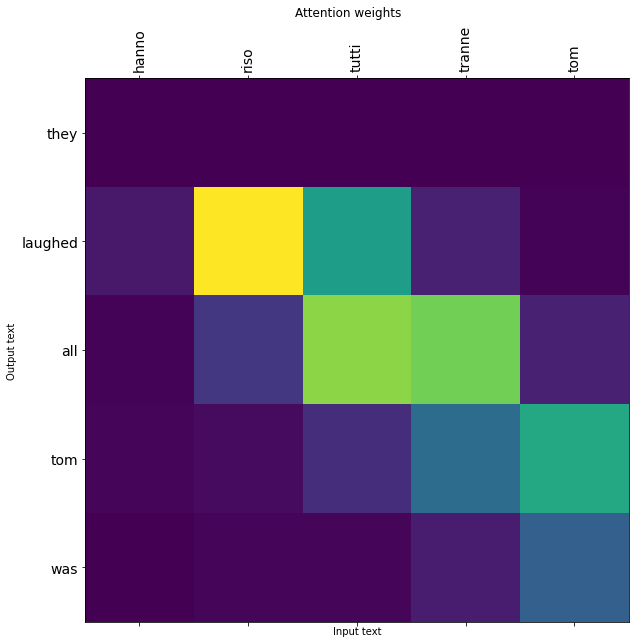

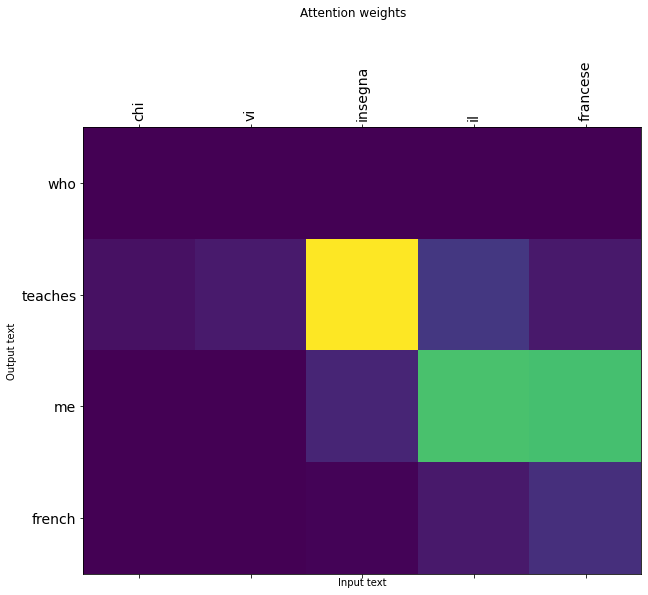

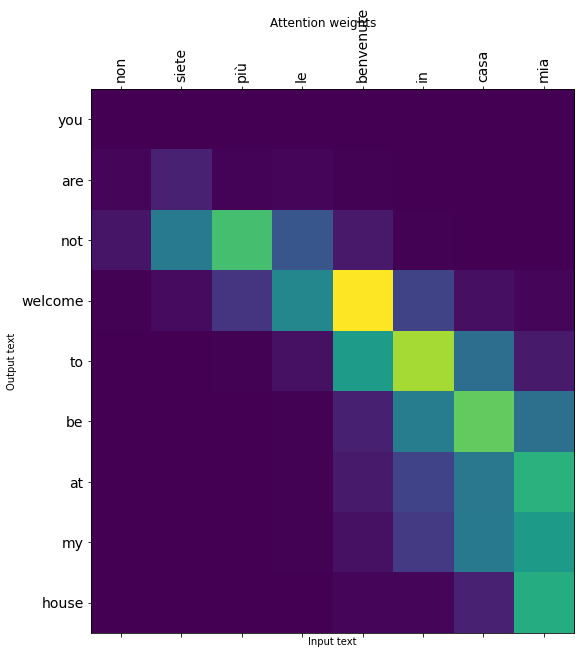

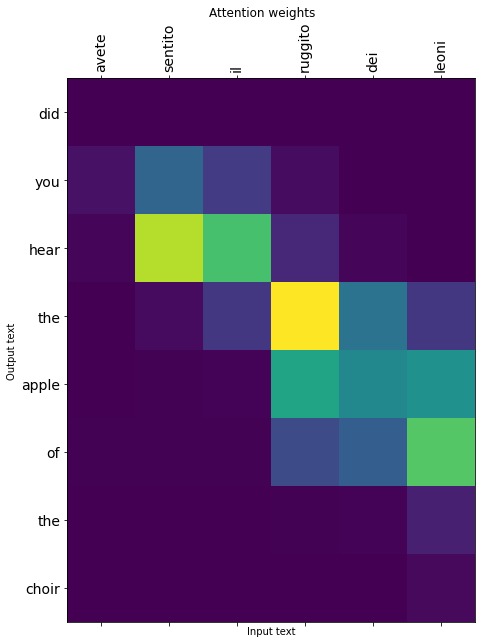

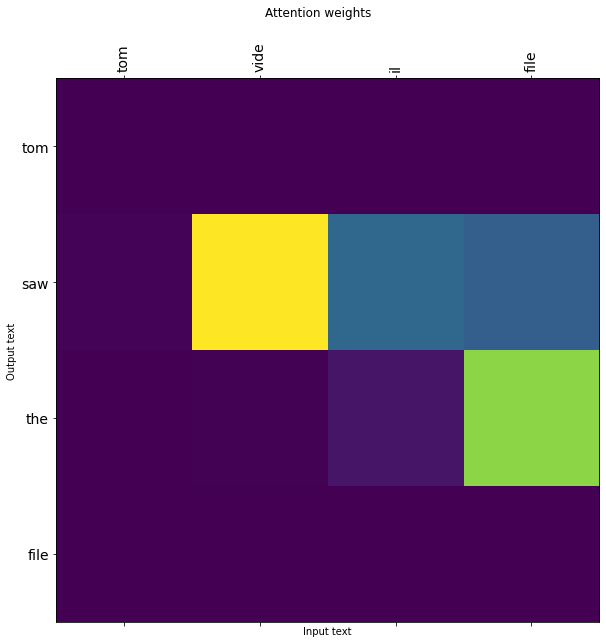

In [ ]:
# Create an object of your custom model.
# Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

BLEU_scores=[]

#model_2.load_weights('model_1_weights.h5')

for i in tqdm(range(5)):
    index= np.random.randint(low=0,high=validation.shape[0])
    
    italian_sentence=validation['italian'].values[index]
    english_sentence=validation['english_out'].values[index]
    
    predicted_words_indices,att_weights,predicted_sentence=predict(italian_sentence,model_2)
    
    reference=english_sentence.split()[:-1]
    translation=predicted_sentence.split()
    
    BLEU_scores.append(bleu.sentence_bleu([reference],translation,weights=[1]))
    print("italian sentence --> ",italian_sentence)
    print("true english translation --> ",english_sentence)
    print("predicted english translation --> ",predicted_sentence)
    print("BLEU Score is : ",BLEU_scores[i])
    
    plot_attention(att_weights,italian_sentence,predicted_sentence)
    print('#'*20)
    

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

BLEU_scores=[]

#model_1.load_weights('model_1_weights.h5')

for i in tqdm(range(1000)):
    index= np.random.randint(low=0,high=validation.shape[0])
    
    italian_sentence=validation['italian'].values[index]
    english_sentence=validation['english_out'].values[index]
    
    predicted_words_indices,att_weights,predicted_sentence=predict(italian_sentence,model_2)
    
    reference=english_sentence.split()[:-1]
    translation=predicted_sentence.split()
    
    BLEU_scores.append(bleu.sentence_bleu([reference],translation,weights=[1]))
    
print('Average_BLEU_score for 1000 random sentences is :',np.mean(BLEU_scores))

100%|██████████| 1000/1000 [00:45<00:00, 22.07it/s]

Average_BLEU_score for 1000 random sentences is : 0.7265969438011216


#### Model 2.2 Implementation with General scoring function

In [ ]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.

from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
import os
import datetime
optimizer = tf.keras.optimizers.Adam()

model_2=encoder_decoder(ip_vocab_size=vocab_size_ita,ip_embed_size=100,op_embed_size=100,input_len=20,lstm_units=64,\
                        att_units=64,output_len=20,op_vocab_size=vocab_size_eng,batch_size=512,score_func='general',emb_matrix=embedding_matrix)

model_2.compile(loss=[loss_function],optimizer=optimizer)

train_steps=train.shape[0]//512
valid_steps=validation.shape[0]//512

log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop = EarlyStopping(monitor="val_loss",mode="auto",patience=7,verbose=1)
checkpt = ModelCheckpoint(monitor="val_loss",mode="auto",filepath='model_2_2_weights.h5',verbose=1,save_best_only=True,save_weights_only=True)
callback_list = [tensorboard_callback,checkpt,earlystop]

model_2.fit(train_dataloader, steps_per_epoch=train_steps, epochs=25, validation_data=train_dataloader,\
                validation_steps=valid_steps,callbacks=callback_list)

model_2.summary()

Epoch 1/25
550/550 [==============================] - ETA: 0s - loss: 1.9661
Epoch 00001: val_loss improved from inf to 1.84727, saving model to model_2_2_weights.h5
550/550 [==============================] - 127s 191ms/step - loss: 1.9661 - val_loss: 1.8473
Epoch 2/25
550/550 [==============================] - ETA: 0s - loss: 1.7988
Epoch 00002: val_loss improved from 1.84727 to 1.72969, saving model to model_2_2_weights.h5
550/550 [==============================] - 99s 180ms/step - loss: 1.7988 - val_loss: 1.7297
Epoch 3/25
550/550 [==============================] - ETA: 0s - loss: 1.6551
Epoch 00003: val_loss improved from 1.72969 to 1.56945, saving model to model_2_2_weights.h5
550/550 [==============================] - 99s 180ms/step - loss: 1.6551 - val_loss: 1.5695
Epoch 4/25
550/550 [==============================] - ETA: 0s - loss: 1.4491
Epoch 00004: val_loss improved from 1.56945 to 1.33011, saving model to model_2_2_weights.h5
550/550 [==============================] - 100s

#### <b><font color='red'>Testing</font></b>

<font color='blue'>**Calculate BLEU score**</font>

 60%|██████    | 3/5 [00:00<00:00,  7.12it/s]

italian sentence -->  tom è stato assalito
true english translation -->  tom was assaulted <end>
predicted english translation -->  tom was assaulted 
BLEU Score is :  1.0
####################
italian sentence -->  vi piace la musica
true english translation -->  do you like music <end>
predicted english translation -->  do you like music 
BLEU Score is :  1.0
####################
italian sentence -->  devi farlo per conto tuo
true english translation -->  you have to do it by yourself <end>
predicted english translation -->  you have to do that by yourself 
BLEU Score is :  0.8571428571428571
####################
italian sentence -->  perché le interessa
true english translation -->  why does that interest you <end>
predicted english translation -->  why do you care 
BLEU Score is :  0.38940039153570244


100%|██████████| 5/5 [00:00<00:00,  8.15it/s]


####################
italian sentence -->  penso che tom sia amico di mary
true english translation -->  i think tom is acquainted with mary <end>
predicted english translation -->  i think tom is friend 
BLEU Score is :  0.5362560368285115
####################


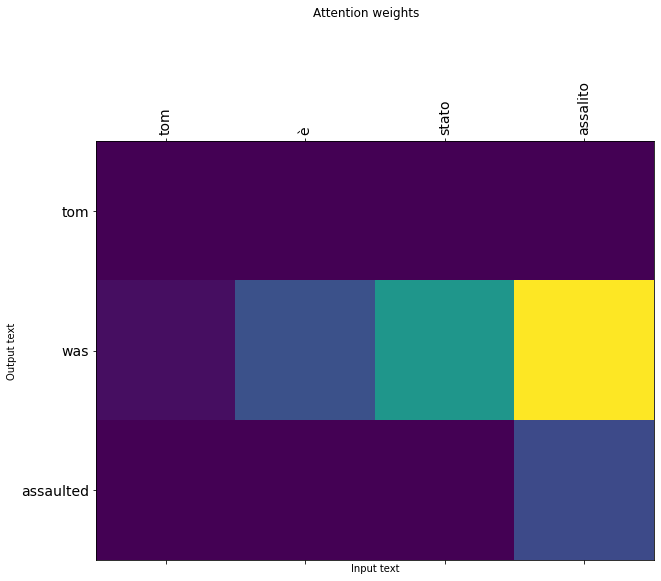

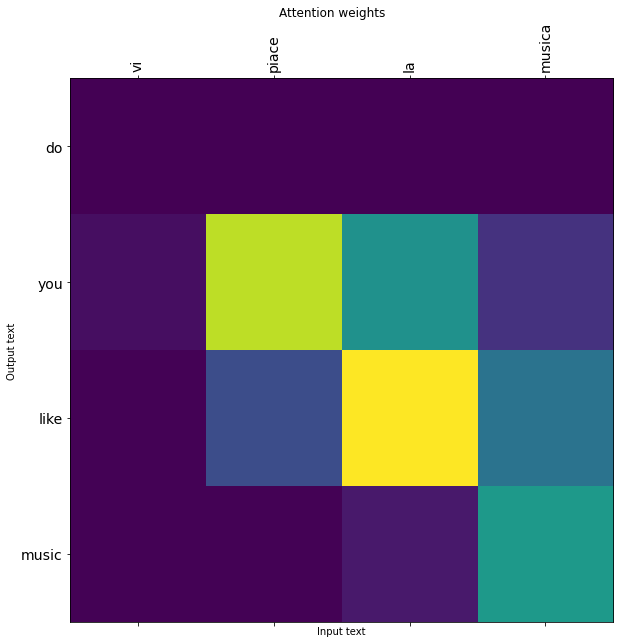

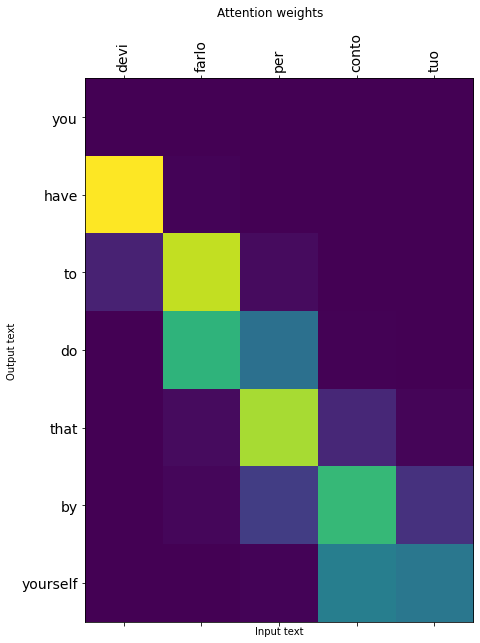

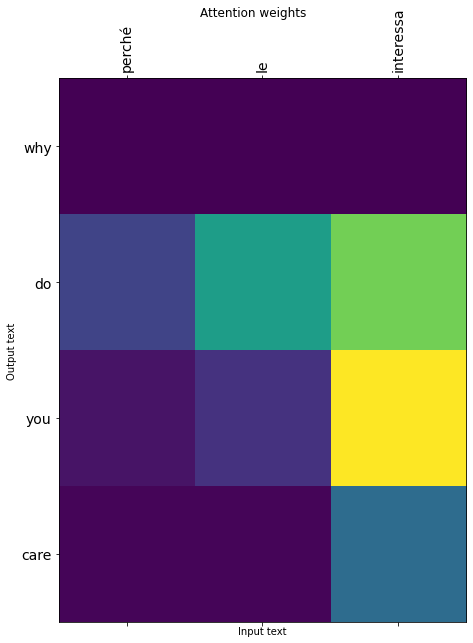

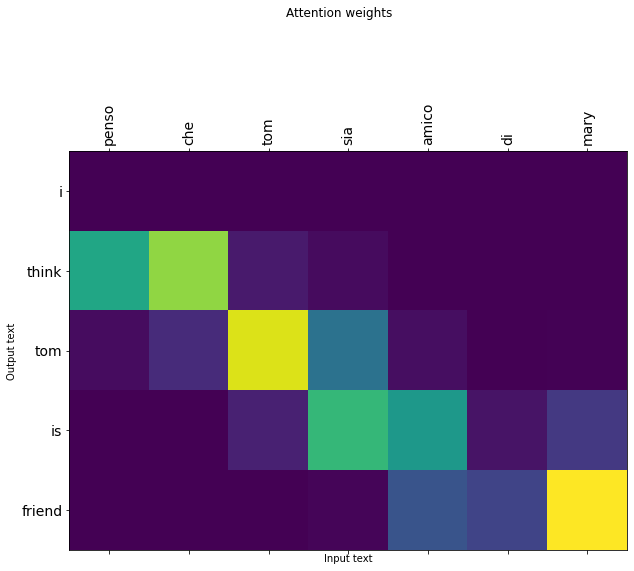

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

BLEU_scores=[]

#model_2.load_weights('model_1_weights.h5')

for i in tqdm(range(5)):
    index= np.random.randint(low=0,high=validation.shape[0])
    
    italian_sentence=validation['italian'].values[index]
    english_sentence=validation['english_out'].values[index]
    
    predicted_words_indices,att_weights,predicted_sentence=predict(italian_sentence,model_2)
    
    reference=english_sentence.split()[:-1]
    translation=predicted_sentence.split()
    
    BLEU_scores.append(bleu.sentence_bleu([reference],translation,weights=[1]))
    print("italian sentence --> ",italian_sentence)
    print("true english translation --> ",english_sentence)
    print("predicted english translation --> ",predicted_sentence)
    print("BLEU Score is : ",BLEU_scores[i])
    
    plot_attention(att_weights,italian_sentence,predicted_sentence)
    print('#'*20)
    

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

BLEU_scores=[]

#model_1.load_weights('model_1_weights.h5')

for i in tqdm(range(1000)):
    index= np.random.randint(low=0,high=validation.shape[0])
    
    italian_sentence=validation['italian'].values[index]
    english_sentence=validation['english_out'].values[index]
    
    predicted_words_indices,att_weights,predicted_sentence=predict(italian_sentence,model_2)
    
    reference=english_sentence.split()[:-1]
    translation=predicted_sentence.split()
    
    BLEU_scores.append(bleu.sentence_bleu([reference],translation,weights=[1]))
    
print('Average_BLEU_score for 1000 random sentences is :',np.mean(BLEU_scores))

100%|██████████| 1000/1000 [00:47<00:00, 20.94it/s]

Average_BLEU_score for 1000 random sentences is : 0.7394842381177127


#### Model 2.3 Implementation with Concat scoring function

In [ ]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)

from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
import os
import datetime
optimizer = tf.keras.optimizers.Adam()

model_2=encoder_decoder(ip_vocab_size=vocab_size_ita,ip_embed_size=100,op_embed_size=100,input_len=20,lstm_units=64,\
                        att_units=64,output_len=20,op_vocab_size=vocab_size_eng,batch_size=512,score_func='concat',emb_matrix=embedding_matrix)

model_2.compile(loss=[loss_function],optimizer=optimizer)

train_steps=train.shape[0]//512
valid_steps=validation.shape[0]//512

log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop = EarlyStopping(monitor="val_loss",mode="auto",patience=7,verbose=1)
checkpt = ModelCheckpoint(monitor="val_loss",mode="auto",filepath='model_2_3_weights.h5',verbose=0,save_best_only=True,save_weights_only=True)
callback_list = [tensorboard_callback,earlystop,checkpt]

model_2.fit(train_dataloader, steps_per_epoch=train_steps, epochs=25, validation_data=train_dataloader,\
                validation_steps=valid_steps,callbacks=callback_list)

model_2.summary()

Epoch 1/25
550/550 [==============================] - 133s 198ms/step - loss: 1.9670 - val_loss: 1.8470
Epoch 2/25
550/550 [==============================] - 103s 187ms/step - loss: 1.7979 - val_loss: 1.6935
Epoch 3/25
550/550 [==============================] - 103s 188ms/step - loss: 1.5288 - val_loss: 1.3790
Epoch 4/25
550/550 [==============================] - 104s 189ms/step - loss: 1.2756 - val_loss: 1.1698
Epoch 5/25
550/550 [==============================] - 104s 190ms/step - loss: 1.0917 - val_loss: 1.0038
Epoch 6/25
550/550 [==============================] - 104s 189ms/step - loss: 0.9411 - val_loss: 0.8658
Epoch 7/25
550/550 [==============================] - 104s 190ms/step - loss: 0.8203 - val_loss: 0.7577
Epoch 8/25
550/550 [==============================] - 104s 189ms/step - loss: 0.7225 - val_loss: 0.6705
Epoch 9/25
550/550 [==============================] - 105s 190ms/step - loss: 0.6431 - val_loss: 0.5967
Epoch 10/25
550/550 [==============================] - 105s 190m

#### <b><font color='red'>Testing</font></b>

<font color='blue'>**Calculate BLEU score**</font>

 40%|████      | 2/5 [00:00<00:00,  7.98it/s]

italian sentence -->  nessuno riusciva a trovare tom
true english translation -->  no one could find tom <end>
predicted english translation -->  no one could find tom 
BLEU Score is :  1.0
####################
italian sentence -->  è stato molto gentile da parte tua di prestarmi un ombrello
true english translation -->  it was very kind of you to lend me an umbrella <end>
predicted english translation -->  it was very kind of your mind to me umbrella umbrella 
BLEU Score is :  0.7272727272727273
####################
italian sentence -->  ci lamentiamo troppo
true english translation -->  we complain too much <end>
predicted english translation -->  it complain it too much 
BLEU Score is :  0.6


100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


####################
italian sentence -->  amo davvero allenarmi
true english translation -->  i really love working out <end>
predicted english translation -->  i really love working out 
BLEU Score is :  1.0
####################
italian sentence -->  silenzio per piacere
true english translation -->  quiet please <end>
predicted english translation -->  they please 
BLEU Score is :  0.5
####################


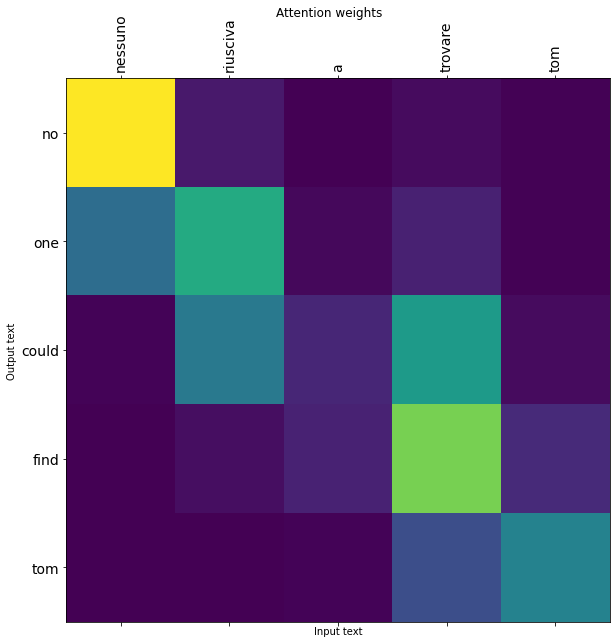

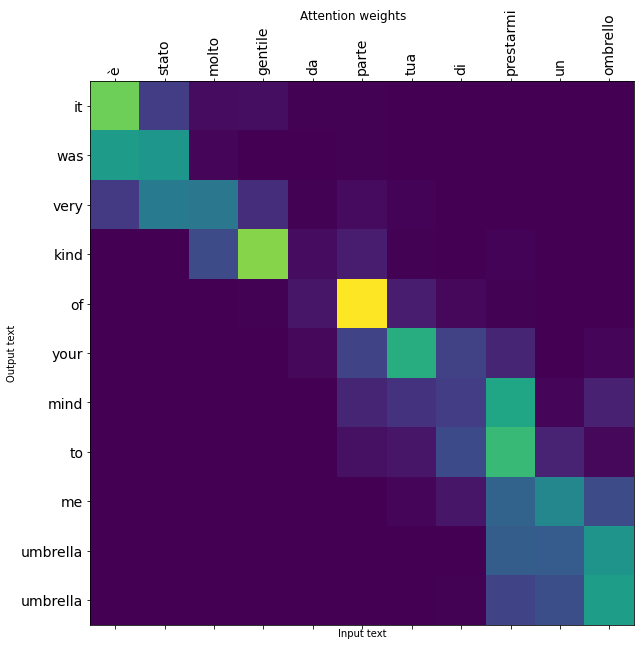

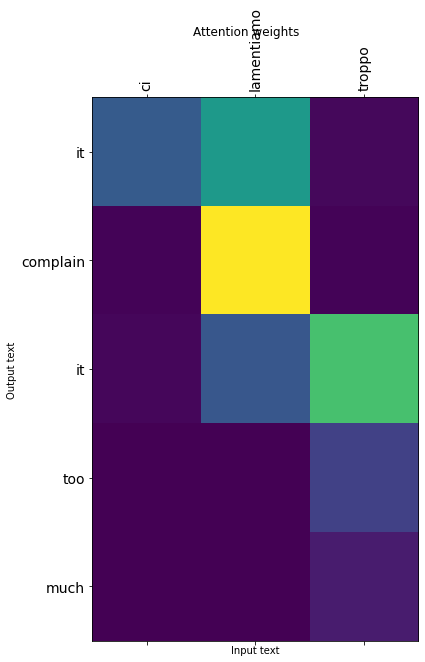

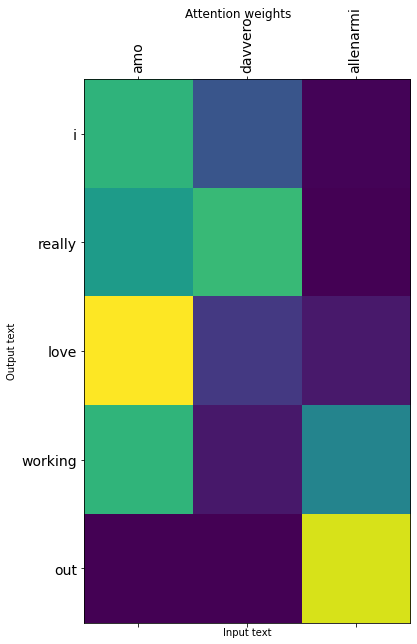

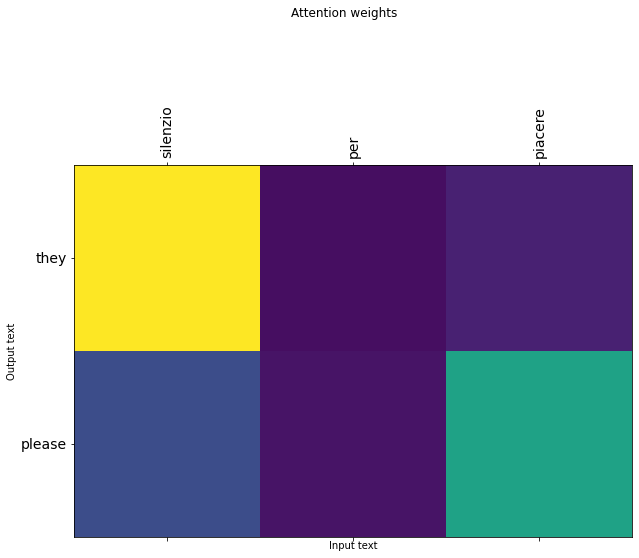

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

BLEU_scores=[]

#model_2.load_weights('model_1_weights.h5')

for i in tqdm(range(5)):
    index= np.random.randint(low=0,high=validation.shape[0])
    
    italian_sentence=validation['italian'].values[index]
    english_sentence=validation['english_out'].values[index]
    
    predicted_words_indices,att_weights,predicted_sentence=predict(italian_sentence,model_2)
    
    reference=english_sentence.split()[:-1]
    translation=predicted_sentence.split()
    
    BLEU_scores.append(bleu.sentence_bleu([reference],translation,weights=[1]))
    print("italian sentence --> ",italian_sentence)
    print("true english translation --> ",english_sentence)
    print("predicted english translation --> ",predicted_sentence)
    print("BLEU Score is : ",BLEU_scores[i])
    
    plot_attention(att_weights,italian_sentence,predicted_sentence)
    print('#'*20)
    

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

import nltk.translate.bleu_score as bleu
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

BLEU_scores=[]

#model_1.load_weights('model_1_weights.h5')

for i in tqdm(range(1000)):
    index= np.random.randint(low=0,high=validation.shape[0])
    
    italian_sentence=validation['italian'].values[index]
    english_sentence=validation['english_out'].values[index]
    
    predicted_words_indices,att_weights,predicted_sentence=predict(italian_sentence,model_2)
    
    reference=english_sentence.split()[:-1]
    translation=predicted_sentence.split()
    
    BLEU_scores.append(bleu.sentence_bleu([reference],translation,weights=[1]))
    
print('Average_BLEU_score for 1000 random sentences is :',np.mean(BLEU_scores))

100%|██████████| 1000/1000 [00:48<00:00, 20.53it/s]

Average_BLEU_score for 1000 random sentences is : 0.7789334684572429


## Observations

In [ ]:
# Write your observations on each of the scoring function
from  prettytable import PrettyTable

x=PrettyTable()
x.field_names = ["Model","similarity scoring function", "Average BLEU score for 1000 random data points"]
x.add_row(["Simple encoder-decoder","None", 0.7115])
x.add_row(["Encoder-decoder with attention ","Dot" ,0.7265])
x.add_row(["Encoder-decoder with attention ","General", 0.7394])
x.add_row(["Encoder-decoder with attention ","Concat", 0.7789])
print(x)


+---------------------------------+-----------------------------+------------------------------------------------+
|              Model              | similarity scoring function | Average BLEU score for 1000 random data points |
+---------------------------------+-----------------------------+------------------------------------------------+
|      Simple encoder-decoder     |             None            |                     0.7115                     |
| Encoder-decoder with attention  |             Dot             |                     0.7265                     |
| Encoder-decoder with attention  |           General           |                     0.7394                     |
| Encoder-decoder with attention  |            Concat           |                     0.7789                     |
+---------------------------------+-----------------------------+------------------------------------------------+
